In [37]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.Profile import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 200, 1000)

## radas

In [7]:
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

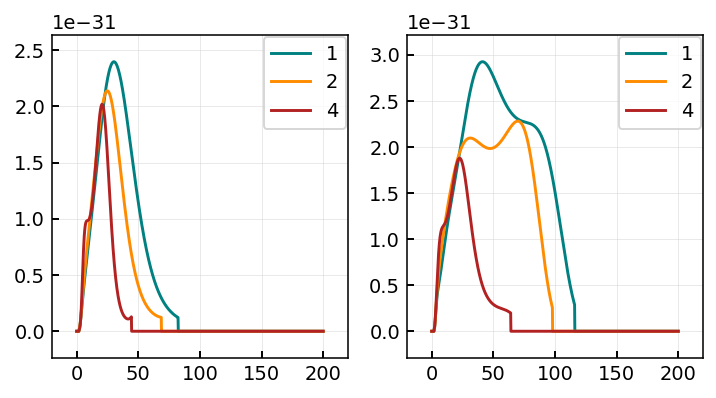

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


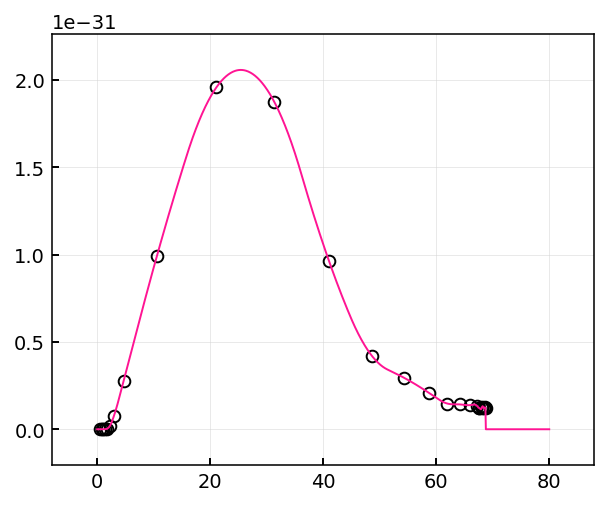

In [9]:
species = "Ar"
param_list = ["Te", f"R{species}", f"f{species}", "ne"]
self = store_slc[case]
sepadd = 2#sepadd_select["outer_lower"]

df = self.get_1d_poloidal_data(param_list, sepadd = sepadd, region = region, target_first = True)
df = df.sort_values(by = "Te")
df[f"R{species}"] = abs(df[f"R{species}"])

upper_limit = df["Te"].max()  # Upper validity limit

df["Lz"] = df[f"R{species}"]/(df["ne"]**2 * df[f"f{species}"])

interp = scipy.interpolate.interp1d(df["Te"], df["Lz"], bounds_error = False, fill_value = 0, kind = "quadratic")

T_new = np.linspace(0,80,1000)
Lz_fit = [interp(T) for T in T_new]

fig, ax = plt.subplots()

ax.plot(df["Te"], df["Lz"], lw = 0, marker = "o", c = "k", markerfacecolor = "None")
ax.plot(T_new, Lz_fit, lw = 1, c = "deeppink")
# ax.set_xlim(0,80)

## Custom

In [10]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz

## Compare curves

### Outer

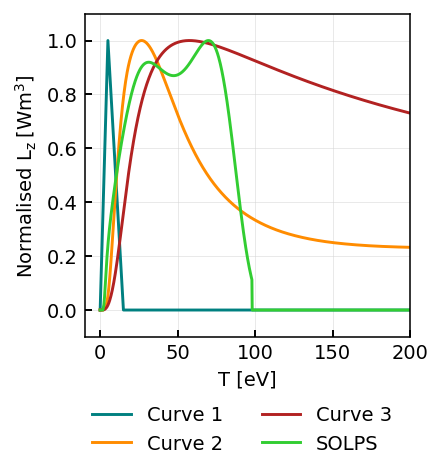

In [11]:
curves["set_outer"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e16],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

### Inner

(-10.0, 200.0)

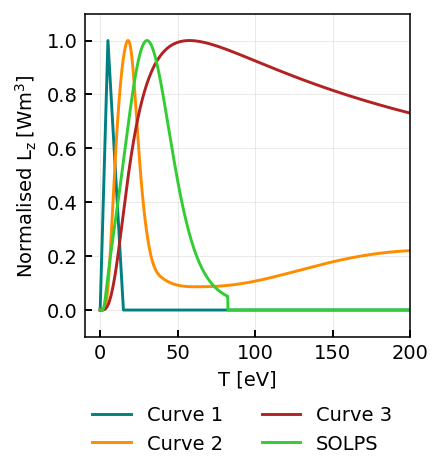

In [ ]:
curves["set_inner"] = {
    "Curve 1" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0),
    "Curve 2" : curves["neTau"][1e20],
    "Curve 3" : curves["neTau"][1e14],
    "SOLPS" : curves["extracted_inner"][sepadd_select["inner_lower"]],
    # "neon" : LfuncKallenbach("Ne")
    # "shoulder" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 23, x2 = 50, height = 0.27),
    # "nitrogen" : lambda temp: LfuncKallenbach("N")(temp),
    # "argon" : lambda temp: LfuncKallenbach("Ar")(temp),
    # "neon" : lambda temp: LfuncKallenbach("Ne")(temp),
    
}
    
fig, ax = plt.subplots(figsize = (3,3))


for name, function in curves["set_inner"].items():
    Lz = [function(temp) for temp in T]
    Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"Normalised $L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 2, frameon = False)
ax.set_xlim(-10,200)

# Profile grid

In [16]:
eqb["100MW_innerar_midplanepuff"]["outer_lower"][3]

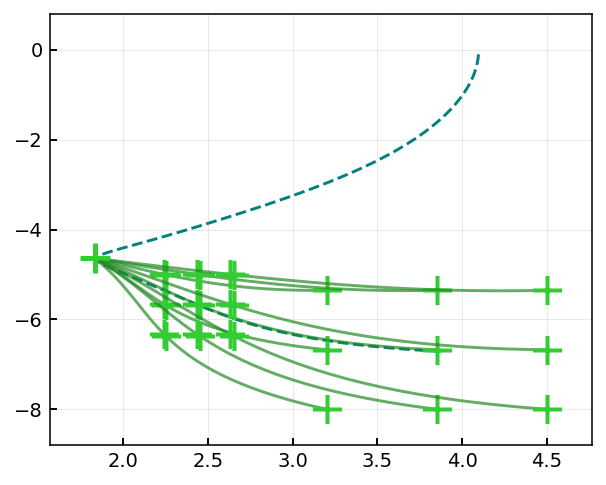

In [245]:
from fusiondls.Profile import cord_spline

base_profile = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
# p.plot_topology()

self = base_profile.copy()

bounding_profiles = {}


R_strike = 4
Z_strike = -10

def get_offsets_strike_point(pos, R_strike, Z_strike):
    
    Z_Xpoint = self["Z"][self["Xpoint"]]
    R_Xpoint = self["R"][self["Xpoint"]]

    R_strike_original = self["R"][0]
    Z_strike_original = self["Z"][0]

    cp = pd.DataFrame() # control points
    # cp["pos"] = [1, 0.5, 0.25, 0]
    cp["pos"] = pos

    spl = cord_spline(self.R_leg, self.Z_leg, return_spline=True)

    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        R, Z = spl(pos)
        cp.loc[i, "R"] = R
        cp.loc[i, "Z"] = Z

    strikeOffsetR = R_strike - R_strike_original
    strikeOffsetZ = Z_strike - Z_strike_original

    # cp["Rdist"] = -1* (cp["R"] - R_strike_original) / (cp["R"].iloc[0] - R_strike_original)
    cp["Rdist"] = (R_Xpoint - cp["R"]) / (R_Xpoint - cp["R"].iloc[-1])
    cp["Zdist"] = (Z_Xpoint - cp["Z"]) / (Z_Xpoint - cp["Z"].iloc[-1])
    cp["Rnew"] = cp["R"] + strikeOffsetR * cp["Rdist"]
    cp["Znew"] = cp["Z"] + strikeOffsetZ * cp["Zdist"]
    cp["offsetx"] = cp["Rdist"]
    cp["offsety"] = cp["Zdist"]
    
    
    offsets = []
    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        offsets.append(dict(
            pos = cp.loc[i, "pos"], 
            xpos = cp.loc[i, "Rnew"], 
            ypos = cp.loc[i, "Znew"],
            # offsetx = cp.loc[i, "offsetx"],
            # offsety = cp.loc[i, "offsety"]
            ))
    return offsets
        
res = 3
xpoints = np.linspace(3.2, 4.5, res)
ypoints = np.linspace(-5.35, -8, res)

profiles = {}

for x in xpoints:
    profiles[x] = {}
    for y in ypoints:
        
        p2 = base_profile.copy()
        offsets = get_offsets_strike_point([1, 0.6, 0.59, 0], x, y)
        p2.offset_control_points(offsets)
        profiles[x][y] = p2

fig, ax = plt.subplots()
ax.plot(p["R"], p["Z"], ls = "--")


for x in xpoints:
    for y in ypoints:
        profiles[x][y].plot_control_points(ax = ax)
# bounding_profiles["left"].plot_control_points(ax = ax)

# ax.set_ylim(-11,None)
# plt.plot(p2["R_original"], p2["Z_original"])

# Run DLS

In [246]:
def run_DLS(constants_input, profile, Spar, slc, cvar, region, sepadd, hflux_corr = 1):
    if "Lfunc" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")
    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }
    
    df = slc.get_1d_poloidal_data(["Ne"], sepadd = sepadd, region = region, target_first = True)
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": 3.42e8,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : slc.extract_cooling_curve("Ar", region, sepadd = sepadd, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }
    
    if Spar == "auto":
        Spar = slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_tot", threshold = 0.05)

    constants = {**constants_default, **constants_input}

    try: 
            out = run_dls(
                constants = constants, 
                radios = radios_default, 
                d = profile,
                SparRange = [Spar],
                control_variable = cvar,
                verbosity = 0,
                Ctol = 1e-4,
                Ttol = 1e-4,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 5,
                dynamicGridRefinementWidth = 2,
                dynamicGridResolution = 10000,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)

comps_outer = {}
store_outer = {}
comps_inner = {}
store_inner = {}

In [247]:
nested_dict = lambda: defaultdict(nested_dict)
store_outer = nested_dict()
comps_outer = nested_dict()
base_outer = {}

In [248]:
study = "outer"
region = "outer_lower"
curve = "Curve 1"
base_profile = eqb_alt['100MW_innerar_midplanepuff'][region][sepadd_select[region]]
 
input = dict(Lfunc = curves["set_outer"][curve])
out, comp = run_DLS(input, base_profile, "auto", store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
base_outer[curve] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving...0.38...Complete in 1.5 seconds


In [249]:
study = "outer"
region = "outer_lower"
curve = "Curve 1"

for x in xpoints:   
    for y in ypoints:

        print(f"Solving profile {x:.2f}, {y:.2f} ------")   
        input = dict(Lfunc = curves["set_outer"][curve])
        out, comp = run_DLS(input, profiles[x][y], "auto", store_slc[case],  "density", region, sepadd_select[region], hflux_corr = 1)  
        comps_outer[curve][x][y] = comp
        store_outer[curve][x][y] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

Solving profile 3.20, -5.35 ------
Solving...0.38...Complete in 1.4 seconds
Solving profile 3.20, -6.67 ------
Solving...0.38...Complete in 1.4 seconds
Solving profile 3.20, -8.00 ------
Solving...0.38...Complete in 1.4 seconds
Solving profile 3.85, -5.35 ------
Solving...0.38...Complete in 1.4 seconds
Solving profile 3.85, -6.67 ------
Solving...0.38...Complete in 1.7 seconds
Solving profile 3.85, -8.00 ------
Solving...0.38...Complete in 2.0 seconds
Solving profile 4.50, -5.35 ------
Solving...0.38...Complete in 2.3 seconds
Solving profile 4.50, -6.67 ------
Solving...0.38...Complete in 2.3 seconds
Solving profile 4.50, -8.00 ------
Solving...0.38...Complete in 2.3 seconds


In [235]:
arr_thresholds = np.zeros((len(xpoints), len(ypoints)))
arr_BxBt = np.zeros_like(arr_thresholds)
arr_Lc = np.zeros_like(arr_thresholds)
thresholds = pd.DataFrame()
cases = nested_dict()
basecase = DLScase(base_outer["Curve 1"])

for i, x in enumerate(xpoints):
    for j, y in enumerate(ypoints):
        dls = DLScase(store_outer["Curve 1"][x][y])
        cases[x][y] = dls
        threshold = dls.stats["cvar"] / basecase.stats["cvar"]
        arr_thresholds[i,j] = 1/threshold
        thresholds.loc[x,y] = 1/threshold
        
        arr_BxBt[i,j] = dls.stats["BxBt"] / basecase.stats["BxBt"]
        # arr_BxBt[i,j] = dls.stats["BxBt"] 
        arr_Lc[i,j] = dls.stats["Lc"] / basecase.stats["Lc"]

In [161]:
thresholds

,-6.1,-7.4,-8.7,-10.0
2.500000,1.664846,1.517729,1.410836,1.330504
3.666667,1.099682,1.039581,0.980635,0.930411
4.833333,0.795826,0.767842,0.735908,0.705650
6.000000,0.616016,0.600310,0.581483,0.562220


# 2D plots

In [221]:
test = lambda x: "{:.2f}".format(x)
test(5)

'5.00'

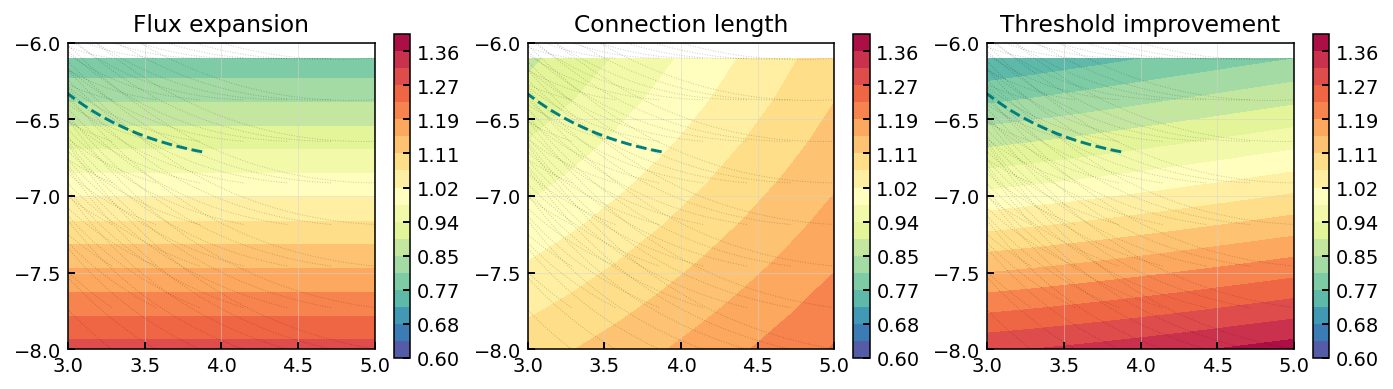

In [238]:
fig, axes = plt.subplots(1,3, figsize = (12,3))

range_all = (0.6,1.4)
range_BxBt = range_all
range_Lc = range_all
range_thresh = range_all
ncontours = 20
cbar_axis_format = mpl.ticker.FuncFormatter(lambda x, pos: "{:.2f}".format(x))

axes[0].set_title("Flux expansion")
cf = axes[0].contourf(xpoints, ypoints, arr_BxBt, levels = np.linspace(*range_BxBt, ncontours), cmap = "Spectral_r", 
                      norm = create_norm(False, None, *range_BxBt), 
                    #   vmin = range_BxBt[0], vmax = range_BxBt[1]
                      )
cbar = fig.colorbar(cf, ax = axes[0])
cbar.ax.yaxis.set_major_formatter(cbar_axis_format)

axes[1].set_title("Connection length")
cf = axes[1].contourf(xpoints, ypoints, arr_Lc, levels = np.linspace(*range_Lc, ncontours), cmap = "Spectral_r", 
                      norm = create_norm(False, None, *range_BxBt))
cbar = fig.colorbar(cf, ax = axes[1])
cbar.ax.yaxis.set_major_formatter(cbar_axis_format)

axes[2].set_title("Threshold improvement")
cf = axes[2].contourf(xpoints, ypoints, arr_thresholds, levels = np.linspace(*range_thresh, ncontours), cmap = "Spectral_r", 
                      norm = create_norm(False, None, *range_BxBt))
cbar = fig.colorbar(cf, ax = axes[2])
cbar.ax.yaxis.set_major_formatter(cbar_axis_format)

for ax in axes:
    ax.plot(base_profile["R"], base_profile["Z"], ls = "--")
    for x in xpoints:
        for y in ypoints:
            profiles[x][y].plot_control_points(
                ax = ax,
                markersettings = {"s":0},
                linesettings = {"linewidth":0.5, "c":"k", "alpha":0.2, "ls" : ":"})     
    ax.set_ylim(-8, -6)
    ax.set_xlim(3,5)
    ax.set_aspect("equal")

In [227]:
basecase.stats


{'cvar': 6.4768853520208626e+19,
 'kappa0': 2861.09503501397,
 'Bf': 1.8120577199523,
 'Bx': 3.284697740386827,
 'Beff': 1.8391062156935662,
 'BxBt': 1.8126893554325036,
 'BxBteff': 1.7860293833807186,
 'Lc': 8.2006222179692,
 'Wradial': 15060740.351901526,
 'Tu': 96.89463307594866,
 'avgB_ratio': 1.2008281960930494,
 'upstream_rad': 6.912538974588556,
 'W_Tu': 0.17075507979615998,
 'W_Tu_simple': 0.3449694242539817,
 'curveclip': 7345043450978.823}

In [ ]:
fig, ax = 

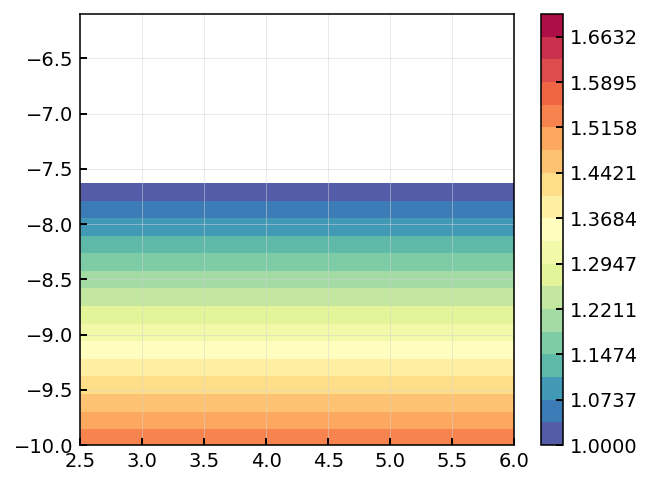

In [186]:
range_BxBt = (1, 1.7)

levels = np.linspace(*range_BxBt, 20)
fig, ax = plt.subplots()

cf = ax.contourf(xpoints, ypoints, arr_BxBt, levels = levels, cmap = "Spectral_r", 
                      norm = create_norm(False, None, *range_BxBt), 
                      )
fig.colorbar(cf, ax = ax)



# 1D breakdown

In [104]:
ypoints

array([ -6.1,  -7.4,  -8.7, -10. ])

In [112]:
y = ypoints[0]

df = pd.DataFrame()

for i, x in enumerate(xpoints):
    dls = DLScase(store_outer["Curve 1"][x][y])
    s = dls.stats
    
    for param in  ["BxBt", "BxBteff", "Lc", "cvar"]:
        df.loc[x, param] = s[param]
        
ratios = df / df.iloc[0,:]
ratios["analytical"] = ratios["BxBt"]**-1 * ratios["Lc"]**(-2/7)
display(ratios)
# display(df)

,BxBt,BxBteff,Lc,cvar,analytical
2.500000,1.000000,1.000000,1.000000,1.000000,1.000000
3.666667,1.466706,1.449077,1.115463,0.660531,0.660843
4.833333,1.933408,1.916317,1.258611,0.478018,0.484324
6.000000,2.400086,2.383737,1.411940,0.370014,0.377545
